HEADER

Required installed python packages:
- ```pandas```
- ```numpy```
- ```ase```
- ```matplotlib```
- ```scipy```

the functions called in the examples are inside ```lib.py``` library file and are import with "```from lib import```" instance.

Examples of the functions that read frequencies from different files (ORCA.hess, g98.out, table.csv) and create a numpy 1D array:

In [1]:
from lib import read_freq_gaussian, read_freq_orca, read_freq_from_csv

freq_h2o = read_freq_orca('data/H2O/h2o.hess')
print('H2O freq:   ' + str(freq_h2o))
freq_nh3 = read_freq_gaussian('data/NH3/nh3.log')
print('NH3 freq:   ' + str(freq_nh3))
freq_ch3oh = read_freq_from_csv('data/freq_methanol_periodic.csv','mol_iso_cry')
print('CH3OH freq: ' + str(freq_ch3oh))

H2O freq:   [1711.756103 3737.174682 3849.077293]
NH3 freq:   [1035.8416 1642.5685 1642.8135 3397.8782 3522.6917 3523.1565]
CH3OH freq: [ 323.2806 1027.9004 1079.2564 1163.6683 1382.4851 1477.2795 1496.6814
 1514.7186 2944.7848 2990.0936 3076.5534 3767.6575]


Examples of reading ```.xyz``` file with ASE and computed mass and inertia moments:

In [2]:
from ase.io import read

methanol = read('data/CH3OH/ch3oh.xyz')
mass	 = methanol.get_masses().sum()
print('Methanol mass [AMU]: ' + str(mass))
inertia_moments = methanol.get_moments_of_inertia()
print('Methanol inertia moments [AMU*A^2]: ' + str(inertia_moments))

Methanol mass [AMU]: 32.041999999999994
Methanol inertia moments [AMU*A^2]: [ 3.92886336 20.41450775 21.15424445]


Example of ZPE correction and Thermal correction to the Binding Energy:

ZPE correction to BE: -10.086504509692986
BH(0):                 60.109995490307014


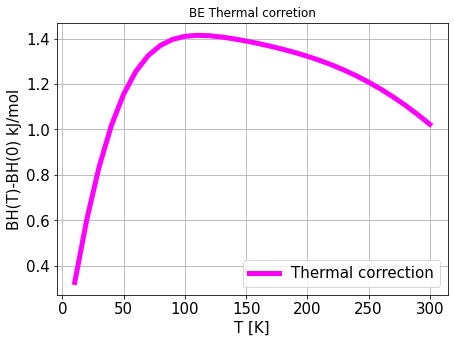

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lib import read_freq_from_csv, BH_t, ZPE

### PARAMETERS and INITIALIZATION ###
step 			= 10	#Temperature steps
t_in 			= 10	#Initial Temperature
t_fin			= 310	#Final Temperature
T 				= np.arange(t_in, t_fin, step,dtype=float) #1D numpy array of Temperature values
tmp_correction	= np.arange(t_in, t_fin, step,dtype=float) #1D numpy array of correction to BE Temperature values

### INPUT INFORMATION ###
ch3oh_be			= 70.1965 #BE without ZPE correction
ch3oh_csv_path		= 'data/freq_methanol_periodic.csv'

### READ FREQUENCIES ###
freq_isolated_mol 	= read_freq_from_csv(ch3oh_csv_path,'mol_iso_cry')
freq_isolated_surf 	= read_freq_from_csv(ch3oh_csv_path,'CH3OH_cry_ref')
freq_complex	 	= read_freq_from_csv(ch3oh_csv_path,'CH3OH_cry_complex')

### ZPE correction to BE ###
zpe_BE 			= ZPE(freq_isolated_mol) + ZPE(freq_isolated_surf) - ZPE(freq_complex)
print('ZPE correction to BE: ' + str(zpe_BE))
BH_0 			= ch3oh_be + zpe_BE
print('BH(0):                 ' + str(BH_0))

### COMPUTE THE THERMAL CORRECTION TO THE BE ###
for i in range(len(T)):
	tmp_correction[i]	= BH_t(T[i],freq_isolated_mol,freq_isolated_surf,freq_complex,False)

### SAVE THERMAL CORRECTION and BH(T) in .csv file ####
df = pd.DataFrame()
df['T'] 			= T
df['Delta_BH_t']	= tmp_correction
BH_T 				= tmp_correction + BH_0
df['BH_t']			= BH_T
with open("tmp/BH_t.csv","w+") as output:
	output.write(df.to_csv(sep="\t", index=False))

### PLOT THE THERMAL CORRECTION ####
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(T, tmp_correction,color='magenta',linewidth=5,label='Thermal correction')
#ax.plot(T, BH_T,color='orange',linewidth=5,label='BH(T)')
ax.set_xlabel('T [K]', fontsize=15)
ax.set_ylabel('BH(T)-BH(0) kJ/mol', fontsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.title('BE Thermal corretion')
ax.grid()
plt.show()

Computed a TPD spectra

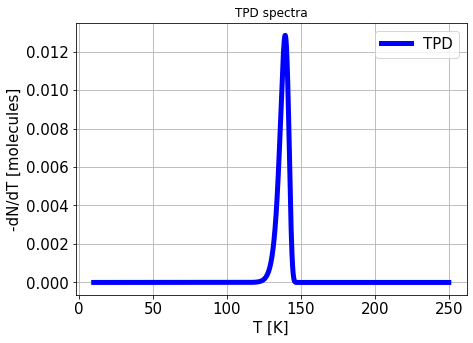

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from lib import BH_t, read_freq_orca, pre_factor_tait, pre_factor_harm, RH_DesRate, pre_factor_HH


### PARAMETERS and INITIALIZATION ###
step 			= 0.1	#Temperature integration step
beta 			= 0.01	#TPD Heating rate [K/s]
N_i  			= 1		#Number/density of species, this value do not affect the TPD since the y-axis can be rapresent as [a.u]
A	 			= 1e-19	#Surface per adsorbed molecules
t_in 			= 10	#Initial Temperature
t_fin			= 250	#Final Temperature
des_order		= 1		#Desorption order
T 				= np.arange(t_in, t_fin, step,dtype=float) 	#1D numpy array of Temperature values
TPD				= np.zeros(len(T),dtype=float) 				#1D numpy array of TPD values
Des_rate		= np.zeros(len(T),dtype=float) 				#1D numpy array of Desorption rate values

### SAMPLE INPUT INFORMATION ###
mol 			= read('data/CH3OH/ch3oh.xyz')	#Isolated adsorbated molecule structure path
mass	 		= mol.get_masses().sum()
inertia_moments = mol.get_moments_of_inertia()
rot_sim			= 1								#Rotational simmetry
BH_0			= 60.11							#BE corrected for ZPE, if not corrected used the BH_T function in the TPD loop

### READ FREQUENCIES ###
freq_isolated_mol 	= read_freq_orca('data/CH3OH/ch3oh.hess')
freq_isolated_surf 	= read_freq_orca('data/CH3OH/CH3OH_309/cluster_opt.hess')
freq_complex	 	= read_freq_orca('data/CH3OH/CH3OH_309/grain_mol_opt.hess')

tmp_N				= 0
for i in range(len(T)):
	bh_t			= BH_0 + BH_t(T[i],freq_isolated_mol,freq_isolated_surf,freq_complex,True) 	#Thermal correction to BE/BH(0)
	#Pre_factor		= pre_factor_HH(mass,A,bh_t) 												#prefactor with HH approximation
	#Pre_factor		= pre_factor_tait(T[i],mass,A,rot_sim,inertia_moments,False) 				#prefactor with Tait approximation
	Pre_factor		= pre_factor_harm(T[i],mass,A,rot_sim,inertia_moments,False,freq_isolated_mol,freq_isolated_surf,freq_complex) #prefactor with Harmonic freq
	Des_rate[i]		= RH_DesRate(T[i],Pre_factor,bh_t)
	if i == 0:
		tmp_N		= N_i - Des_rate[i] * N_i ** des_order / beta * step
		TPD[i]  	= Des_rate[i] * N_i ** des_order  / beta * step
	else:
		tmp 		= Des_rate[i] * tmp_N ** des_order / beta * step
		if tmp_N - tmp <= 0:
			tmp_N	= 0
		else:
			tmp_N	= tmp_N - tmp
			TPD[i]	= tmp

### SAVE TPD spectra and RATE CONSTANT in .csv file ####
df = pd.DataFrame()
df['T'] 			= T
df['TPD']			= TPD
df['Des_rate']		= Des_rate
with open("tmp/TPD.csv","w+") as output:
	output.write(df.to_csv(sep="\t", index=False))

### PLOT TPD spectra ####
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(T, TPD,color='blue',linewidth=5,label='TPD')
ax.set_xlabel('T [K]', fontsize=15)
ax.set_ylabel('-dN/dT [molecules]', fontsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.title('TPD spectra')
ax.grid()
plt.show()

Fit the Desorption rate with Arrehnius-Kooji, example from the BE sample above

Alpha: 4.957E+17 s-1
Beta:  3.547E-01 K
Gamma: 6.440E+03 K


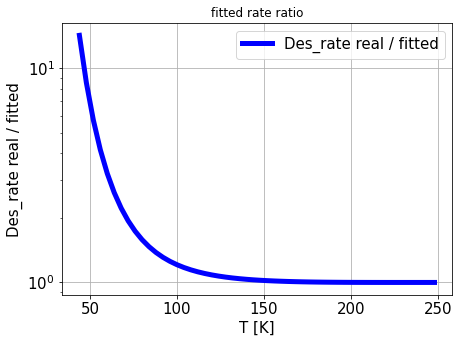

TPD peak from real desorption rate:      140.0 K
TPD peak with Arrehnius-kooji paramters: 139.5 K


In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize
from lib import kooji, kJmoltoK

### INPUT ###
BH_0 	= 60.11 #BH(0) of the sample computed

### READ Desorption rate computed ###
with open('tmp/TPD.csv',"r") as data:
	df = pd.read_csv(data, delimiter = '\t', index_col=False)

### Decrease the number of points in the fitting procedure ###
df = df[df['T'] > 40]
df['T'] = df['T'].round(2) 
#df = df[df['T']<200]
df = df[df['T'] % 4 == 0]

### Convert the data in numpy array from pandas ###
T = pd.Series(df['T'].to_numpy(dtype=float))
k = pd.Series(df['Des_rate'].to_numpy(dtype=float))

### FIT Arrehnius-kooji equation ###
#!!! ATTENTION: The fitting alghoritms straggle sometimes to find a solution, you should play with intial condition and bounds if needed !!!#
par_i = [1e18,-1e-3,BH_0*kJmoltoK]											#initial parameters
par_b = ([0,-np.inf,BH_0*kJmoltoK-300],[np.inf,np.inf,BH_0*kJmoltoK+300])	#buonds for parameters 

popt_kooji, pcov = curve_fit(kooji, T, k, p0=par_i, maxfev=5000)
print('Alpha: ' + str(f"{popt_kooji[0]:.3E}") + str(' s-1') + '\nBeta:  ' + str(f"{popt_kooji[1]:.3E}") + str(' K') + '\nGamma: ' + str(f"{popt_kooji[2]:.3E}") + str(' K'))

### PLOT fitted rate ratio ####
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(T, k/kooji(T, *popt_kooji),color='blue',linewidth=5,label='Des_rate real / fitted')
ax.set_xlabel('T [K]', fontsize=15)
ax.set_ylabel('Des_rate real / fitted', fontsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.title('fitted rate ratio')
plt.yscale('log')
ax.grid()
plt.show()

### Find TPD peak with Arrehnius-kooji parameters ###
alpha 	= popt_kooji[0]
nu 		= popt_kooji[1]
gamma 	= popt_kooji[2]

def tpd_peak(T):
	"""
	Function for TPD peak with Desorption rate encoded as Arrehnius-kooji equation
	t: Temperature
	alpha, beta and gamma: the parameters are respectivetly in s-1, K and K
	"""
	return  nu * T + gamma - 1 / beta * T * T * alpha * (T / 300) ** nu * np.exp( - gamma / T)

popt_tpd_peak = optimize.bisect(tpd_peak, 1,300)

print('TPD peak from real desorption rate:      ' + str(round(df.loc[df['TPD']==df['TPD'].max()]['T'].iat[0],1)) + ' K')
print('TPD peak with Arrehnius-kooji paramters: ' + str(round(popt_tpd_peak,1)) + ' K')

Fit the q_ratio with the choose function, example from water

Effective frequancy: 81.87253621379651


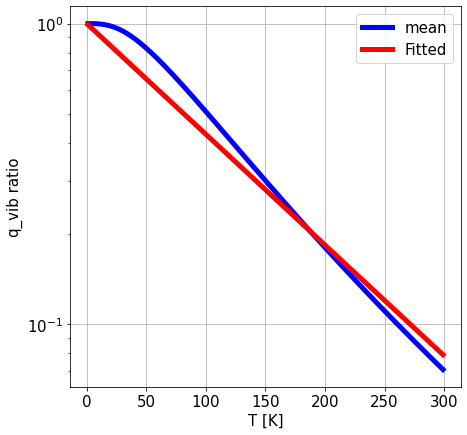

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize
from lib import CMtoK

with open("tmp/H2O_q_ratio_mean.csv","r") as data:
	df_tmp = pd.read_csv(data, delimiter = '\t', index_col=False)

def fit_function(T,freq):
    return  np.log10(np.exp(- T/ freq / CMtoK))

T 			= df_tmp['T'].to_numpy()
q_vib_mean  = np.log10(df_tmp['mean'].to_numpy())

par_i = [50]					#initial parameters

popt, pcov = curve_fit(fit_function, T, q_vib_mean, maxfev=50000000)

print('Effective frequancy: ' + str(popt[0]))

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(T, np.power(10,q_vib_mean),color='blue',linewidth=5,label='mean')
ax.plot(T, np.power(10,fit_function(T, *popt)),color='red',linewidth=5,label='Fitted')
ax.set_xlabel('T [K]', fontsize=15)
ax.set_ylabel('q_vib ratio', fontsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.yscale('log')
ax.grid()
plt.show()